In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import f1_score
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from scipy import sparse
from module import *

def setup_seed(seed):

    np.random.seed(seed) 
    random.seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)  
    
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.enabled = False  
    torch.backends.cudnn.benchmark = False  
    torch.set_float32_matmul_precision('high')
    print("seed set ok!")
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
setup_seed(3407)

import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    
# 定义一个函数，用于加载文件中的数据
# 定义一个函数，用于加载文件中的数据
    # 打开文件，以二进制模式读取
def load_data(filename):
        # 使用pickle模块加载文件中的数据
    with open(filename, 'rb') as f:
    # 返回加载的数据
        data = pickle.load(f)
    return data

seed set ok!


In [2]:
from torch.utils.data import Dataset
class scDataset(Dataset):
    def __init__(self,index,mode):
        # 初始化函数，传入index和mode
        self.path='/home/share/huadjyin/home/zhouxuanchi/HIV/atac_to_gene_new_data_0218/adata_process'
        self.stage=np.load('/home/share/huadjyin/home/zhouxuanchi/HIV/new_atac_and_gene_to_class/HDs_INRs/data/stage.npy')
        self.index_list=index
        self.mode=mode
    def __len__(self):
        return len(self.index_list)
    def get_np_array(self, filename):
        return np.load(os.path.join(self.path, filename))
    def __getitem__(self, idx):
        index_name=self.index_list[idx]
        array_idx=self.get_np_array(str(index_name)+'.npy')
        
        tensor_all=torch.tensor(array_idx, dtype=torch.bfloat16)
        mask=torch.tensor((tensor_all[:582] != 0), dtype=torch.bfloat16)
        gene = tensor_all[:582]
        peak = tensor_all[582:]
        label=self.stage[index_name]
        if self.mode=='hds_or_inrs':
            if label=='HDs':
                label=torch.tensor(0,dtype=torch.float32)
            else:
                label=torch.tensor(1,dtype=torch.float32)
        elif self.mode=='hds_or_irs':
            if label=='HDs':
                label=torch.tensor(0,dtype=torch.float32)
            else:
                label=torch.tensor(1,dtype=torch.float32)
        elif self.mode=='irs_or_inrs':
            if label=='IRs':
                label=torch.tensor(0,dtype=torch.float32)
            else:
                label=torch.tensor(1,dtype=torch.float32)
        else:
            return  ValueError("some error.")
        return gene, peak,mask,label

In [3]:
dict_sample_stage=load_data('./data/dict_sample_stage.pkl')

In [4]:

test_list=['HD-H162','HD-H323','HD-H330','HD-H150','HD-H325','PD-H292','PD-H262','PD-H296','PD-H279','PD-H297','PD-H263','PD-H232','PD-H230','PD-H237','PD-H233']
hds_test=test_list[0:5]
inrs_test=test_list[10:15]
irs_test=test_list[5:10]
mode='irs_or_inrs'

In [5]:


class HIVModel(pl.LightningModule):
    def __init__(self, input_dim=64, hidden_dim=512):
        super().__init__()

        self.gene_encoder = TokenizedFAEncoder(582, 64, True, 7, 0.1, 'layernorm')
        self.peak_encoder = TokenizedFAEncoder(5583, 64, True, 7, 0.1, 'layernorm')
        self.decoder = GatedMLP(in_features=2*64, out_features=1)
        self.matrix=torch.load('/home/share/huadjyin/home/zhouxuanchi/HIV/atac_to_gene_new_data_0218/data/mask_mat.pt')
    def forward(self, gene, peak,mask_gene):   
        matrix=torch.tensor(self.matrix,device=mask_gene.device)
        mask_peak=torch.mm(mask_gene,matrix)
        mask_gene = torch.cat((torch.zeros(size=(mask_gene.shape[0],1), dtype=torch.bfloat16,device=mask_gene.device), mask_gene), dim=1)
        mask_peak = torch.cat((torch.zeros(size=(mask_peak.shape[0],1), dtype=torch.bfloat16,device=mask_gene.device), mask_peak), dim=1)
        #[B, 582] -> [B, 583, 64]
        gene = self.gene_encoder(gene,mask_gene)
        #[B, 5583] -> [B, 5584, 64]
        peak = self.peak_encoder(peak,mask_peak)
        
        if mask_gene is not None:
        
            m = mask_gene.unsqueeze(-1).float()
            gene = (gene * m).sum(1) / m.sum(1)  
        if mask_peak is not None:
            m = mask_peak.unsqueeze(-1).float()
            peak = (peak * m).sum(1) / m.sum(1)
        x = torch.cat((gene, peak), dim=1)
        # [B, 64] -> [B, 1] -> [B]
        x = self.decoder(x).squeeze()
        return x

    def training_step(self, batch, batch_idx):

        gene, peak,mask,label= batch
        label_stage = label.view(-1)

        pred_stage = self(gene, peak,mask)
        label_stage=label_stage.squeeze(dim=-1)
        loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))(pred_stage, label_stage)

        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):

        gene, peak,mask,label= batch
        
        label_stage = label.view(-1)

        pred_stage = self(gene, peak,mask)
        label_stage=label_stage.squeeze(dim=-1)
        loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))(pred_stage, label_stage)

        self.log('val_loss', loss)

        return loss
    
    def predict_step(self, batch, batch_idx):
        gene, peak,mask,label= batch
        label_stage = label.unsqueeze(1).float()
        pred_stage = self(gene, peak,mask)


        return label_stage, pred_stage
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
        optim_dict = {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': step_lr_scheduler,
                'monitor': 'val_loss',
            }
        }
        return optim_dict

In [6]:
trainer = pl.Trainer(
    accelerator='gpu',  
    devices=[2],
    precision='bf16-mixed',
)
model = HIVModel.load_from_checkpoint("./model/hiv_model-epoch=50-val_loss=0.4251.ckpt",map_location='cpu')

Using bfloat16 Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    
# 定义一个函数，用于加载文件中的数据
# 定义一个函数，用于加载文件中的数据
    # 打开文件，以二进制模式读取
def load_data(filename):
        # 使用pickle模块加载文件中的数据
    with open(filename, 'rb') as f:
    # 返回加载的数据
        data = pickle.load(f)
    return data
dict_output={}

##################
sample_list=irs_test+inrs_test
###################
dict_sample_cell=load_data('./data/dict_sample_cell.pkl')
for test_sample in sample_list:
    idx_list=dict_sample_cell[test_sample]
    dataset_test=scDataset(idx_list,mode)
    
    test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=8)
    output=trainer.predict(model, test_loader)
    test_true = np.concatenate([x.float().cpu().detach() for x, y in output])
    test_pred = np.concatenate([y.float().cpu().detach() for x, y in output])
    dict_output[test_sample]=(test_true,test_pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    
# 定义一个函数，用于加载文件中的数据
# 定义一个函数，用于加载文件中的数据
    # 打开文件，以二进制模式读取
def load_data(filename):
        # 使用pickle模块加载文件中的数据
    with open(filename, 'rb') as f:
    # 返回加载的数据
        data = pickle.load(f)
    return data



In [9]:
import torch
dict_iwant={}
sigmoid = torch.nn.Sigmoid()
for key in dict_output.keys():
    test_true,test_pred=dict_output[key]
    test_pred=torch.tensor(test_pred)
    test_true=torch.tensor(test_true)
    test_pred = sigmoid(test_pred).squeeze().numpy()
    test_true = test_true.squeeze().numpy()
    dict_iwant[key] = (test_pred,test_true)

save_data(dict_iwant,'./data/dict_iwant2.pkl')

Data saved to ./data/dict_iwant2.pkl


In [1]:
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    
# 定义一个函数，用于加载文件中的数据
# 定义一个函数，用于加载文件中的数据
    # 打开文件，以二进制模式读取
def load_data(filename):
        # 使用pickle模块加载文件中的数据
    with open(filename, 'rb') as f:
    # 返回加载的数据
        data = pickle.load(f)
    return data
dict_iwant=load_data('./data/dict_iwant2.pkl')
import numpy as np
list_pred=[]
list_true=[]
for key in dict_iwant.keys():
    test_pred,test_true=dict_iwant[key]
    list_pred.append(test_pred)
    list_true.append(test_true)
pred_scores = np.concatenate(list_pred)
labels = np.concatenate(list_true)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(labels, pred_scores)
best_threshold1 = thresholds[np.argmin(np.abs(precision - recall))]

Best Threshold: 0.4559252


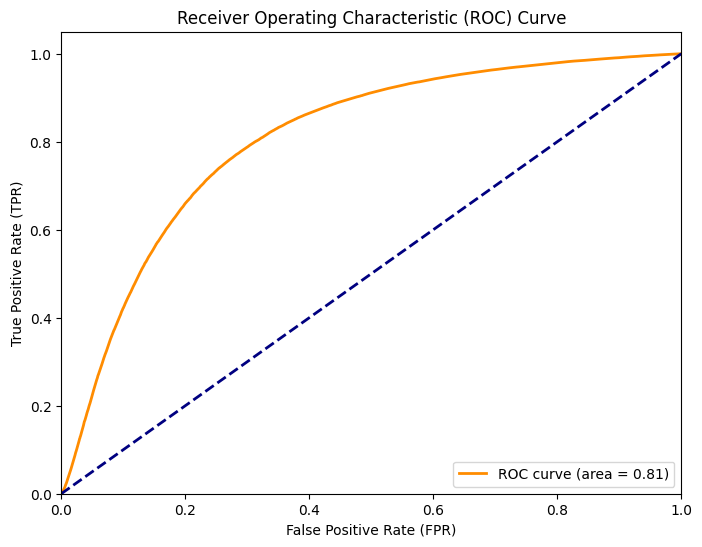

In [3]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(labels, pred_scores)
# 计算约登指数
j_scores = tpr + (1 - fpr) - 1
# 找到最大约登指数对应的阈值
best_threshold = thresholds[np.argmax(j_scores)]
print("Best Threshold:", best_threshold)
from sklearn.metrics import roc_curve, auc
y_test=labels
y_prob=pred_scores
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

PD-H292 0.0 0: 0.82 1: 0.17
PD-H262 0.0 0: 0.37 1: 0.62
PD-H296 0.0 0: 0.72 1: 0.27
PD-H279 0.0 0: 0.90 1: 0.09
PD-H297 0.0 0: 0.84 1: 0.15
PD-H263 1.0 0: 0.28 1: 0.71
PD-H232 1.0 0: 0.26 1: 0.73
PD-H230 1.0 0: 0.27 1: 0.72
PD-H237 1.0 0: 0.22 1: 0.77
PD-H233 1.0 0: 0.27 1: 0.72


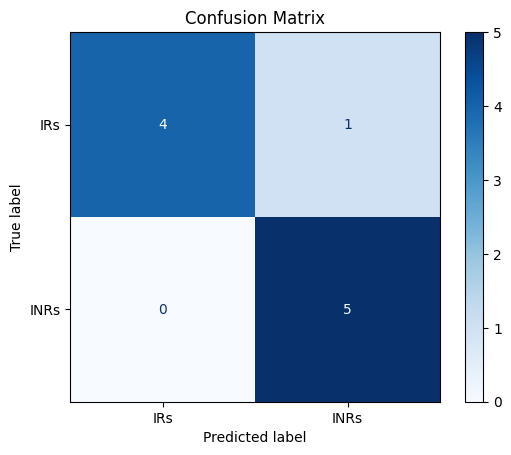

In [4]:
key_list=[]
import torch
from scipy.stats import mode
label_true=[]
pred_label=[]

for key in dict_iwant.keys():

    test_pred,test_true=dict_iwant[key]
    result = np.where(test_pred < best_threshold1, 0, 1)
    unique_elements, counts = np.unique(result, return_counts=True)
    counts=counts/(counts.sum())

    mode_value = mode(result)[0]
    key_list.append(key)
    if len(counts) == 1:
        print(key,test_true[0],mode_value.item())
    else:
        print(key,test_true[0],'0:',str(counts[0])[0:4],'1:',str(counts[1])[0:4])
    label_true.append(test_true[0].item())
    pred_label.append(mode_value.item())
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 示例数据：真实标签和预测标签
y_true = label_true# 真实标签
y_pred = pred_label  # 预测标签

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
class_labels = ['IRs', 'INRs']
# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 使用蓝色调色板，并显示数字
plt.title("Confusion Matrix")
# plt.savefig("/home/share/huadjyin/home/zhouxuanchi/HIV/pdf/irs_inrs.pdf",dpi=300, bbox_inches='tight', pad_inches =0)
plt.show()

In [6]:
import pickle
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")
    
# 定义一个函数，用于加载文件中的数据
# 定义一个函数，用于加载文件中的数据
    # 打开文件，以二进制模式读取
def load_data(filename):
        # 使用pickle模块加载文件中的数据
    with open(filename, 'rb') as f:
    # 返回加载的数据
        data = pickle.load(f)
    return data
df_all=load_data('./data/df_all.pkl')
from sklearn.metrics import f1_score
dict_iwant=load_data('./data/dict_iwant2.pkl')

test_list=['HD-H162','HD-H323','HD-H330','HD-H150','HD-H325','PD-H292','PD-H262','PD-H296','PD-H279','PD-H297','PD-H263','PD-H232','PD-H230','PD-H237','PD-H233']
hds_test=test_list[0:5]
inrs_test=test_list[10:15]
irs_test=test_list[5:10]
mode='irs_or_inrs'
idx_all_list=[]
pred_all_list=[]
label_all_list=[]
import numpy as np
dict_sample_cell=load_data('./data/dict_sample_cell.pkl')
sample_list=irs_test+inrs_test
for test_sample in sample_list:
    idx_all_list=idx_all_list+dict_sample_cell[test_sample]
    pred_all_list=pred_all_list+np.where(dict_iwant[test_sample][0] < best_threshold1, 0, 1).tolist()
    label_all_list=label_all_list+dict_iwant[test_sample][1].tolist()
df_new=df_all.iloc[idx_all_list]
df3=df_new.loc[:,['rna_sample','rna_stage','celltype_L3']]
df3['pred']=pred_all_list
df3['label']=label_all_list
import pandas as pd
df_want_l3_f1=pd.DataFrame(columns=['celltype_L3','IRs_INRs'])
celltype_l3_list=load_data('./data/celltype_L3.pkl')
for celltypeL3 in celltype_l3_list:
    df3_linshi=df3[df3['celltype_L3']==celltypeL3]
    
    pred=df3_linshi['pred'].tolist()
    label=df3_linshi['label'].tolist()
    f1=f1_score(label,pred)

    df_want_l3_f1.loc[len(df_want_l3_f1)]=[celltypeL3,f1]


In [7]:
df_want_l3_f1

,celltype_L3,IRs_INRs
0,CD8_CTL-GZMB,0.780948
1,cMono-CD14,0.737006
2,CD8_Naive_T-CCR7,0.747732
3,NKT-NCR1,0.728178
4,CD4_Naive_T-CCR7,0.478322
5,CD8_Tcm-GZMK,0.737210
6,Naive_B-TCL1A,0.723463
7,CD8_Tem-GZMK,0.752011
8,Mature_NK_dim-FCGR3A,0.720275
9,CD8_CTL-GZMK,0.748062


In [8]:
save_data(df_want_l3_f1,'./data/df_want_l3_f1.pkl')

Data saved to ./data/df_want_l3_f1.pkl
